<a href="https://colab.research.google.com/github/sri-spirited/fastai_course_v3_notes/blob/master/1_2_Cell_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal**
Classify image cells as infected with Malaria or not 

**Data**
* [Kaggle Malaria Cell Images dataset](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria)
* The dataset contains 2 folders - Infected - Uninfected
* Total 27,558 images.

In [0]:
# Install the Kaggle API client if required
# !pip install -q kaggle

Upload the `kaggle.json` file, needed to connect to Kaggle datasets through its API.

In [0]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

User uploaded file "kaggle.json" with length 65 bytes


In [0]:
# Go to the Kaggle competition page you would like to download data from , and browse to Data
# Scroll down to the data section and click API button, it will copy the command automatically.
#!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p /content
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 98% 332M/337M [00:07<00:00, 35.0MB/s]
100% 337M/337M [00:07<00:00, 47.5MB/s]


In [0]:
!ls -a

.  ..  cell-images-for-detecting-malaria.zip  .config  sample_data


In [0]:
!unzip cell-images-for-detecting-malaria.zip

In [0]:
ls -a

./   cell_images/                           .config/
../  cell-images-for-detecting-malaria.zip  sample_data/


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from fastai import *
from fastai.callbacks.hooks import *
from fastai.vision import *
from fastai.metrics import accuracy


In [0]:
print(os.listdir('cell_images'))

['Uninfected', 'Parasitized']


### Dataset 

In [0]:
img_dir = 'cell_images'

In [0]:
path = Path(img_dir)
path

PosixPath('cell_images')

In [0]:
data = ImageDataBunch.from_folder(path, 
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0), 
                                  size=224, 
                                  bs=64, 
                                  valid_pct=0.2).normalize(imagenet_stats)

In [0]:
data

ImageDataBunch;

Train: LabelList (22047 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Uninfected,Uninfected,Uninfected,Uninfected,Uninfected
Path: cell_images;

Valid: LabelList (5511 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Uninfected,Parasitized,Uninfected,Uninfected,Parasitized
Path: cell_images;

Test: None

In [0]:
fnames = get_image_files(path/'Parasitized')
fnames[:5]

[PosixPath('cell_images/Parasitized/C130P91ThinF_IMG_20151004_142109_cell_138.png'),
 PosixPath('cell_images/Parasitized/C136P97ThinF_IMG_20151005_141803_cell_108.png'),
 PosixPath('cell_images/Parasitized/C84P45ThinF_IMG_20150818_101412_cell_102.png'),
 PosixPath('cell_images/Parasitized/C126P87ThinF_IMG_20151004_104728_cell_128.png'),
 PosixPath('cell_images/Parasitized/C157P118ThinF_IMG_20151115_163759_cell_189.png')]

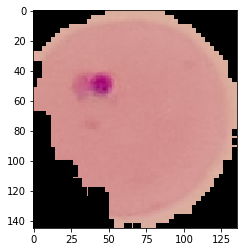

In [0]:
img = plt.imread(f'{fnames[0]}')
plt.imshow(img);

In [0]:
img.shape

(145, 136, 3)

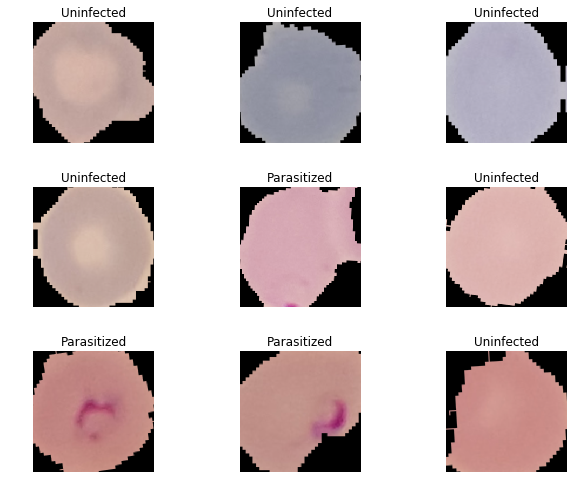

In [0]:
data.show_batch(rows=3, figsize=(9,7))

In [0]:
print('Classes: ', data.classes, '\n', 'Length: ', len(data.classes))

Classes:  ['Parasitized', 'Uninfected'] 
 Length:  2


In [0]:
ShowGraph(learn)

learn = cnn_learner(data, base_arch=models.resnet34, metrics=accuracy, model_dir='/model', callback_fns=ShowGraph)

In [0]:
%%timeit
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.209217,0.152825,0.944656,02:33
1,0.157427,0.132859,0.950644,02:32
2,0.151127,0.119682,0.955725,02:33
3,0.139308,0.117229,0.956995,02:37


epoch,train_loss,valid_loss,accuracy,time
0,0.136919,0.116637,0.958084,02:33
1,0.139249,0.117238,0.955906,02:33
2,0.124991,0.106937,0.959898,02:35
3,0.112272,0.107226,0.958991,02:34


epoch,train_loss,valid_loss,accuracy,time
0,0.122822,0.107168,0.960080,02:33
1,0.129127,0.106938,0.961531,02:35
2,0.109115,0.101039,0.963890,02:34
3,0.111478,0.101067,0.965161,02:35


epoch,train_loss,valid_loss,accuracy,time
0,0.107633,0.103034,0.963890,02:36
1,0.121981,0.100712,0.963165,02:37
2,0.103386,0.096457,0.965161,02:34
3,0.104484,0.095607,0.965523,02:36


1 loop, best of 3: 10min 16s per loop


In [0]:
%%timeit
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


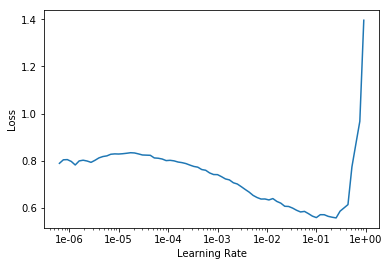

In [0]:
learn.recorder.plot()

Training the model using the learning rate of 1e-01

In [0]:
learn.fit_one_cycle(4, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.195792,0.146102,0.949918,03:42
1,0.147957,0.113111,0.958628,03:32
2,0.125404,0.101365,0.966975,03:48
3,0.111204,0.092503,0.967157,03:48


In [0]:
1e

Accuracy fell with 1e-01, so used 1e-02 instead

Does the accuracy improve? 

In [0]:
learn.save('stage-1')

In [0]:
# Lets set all the layer groups except the last one to be untrainable.
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


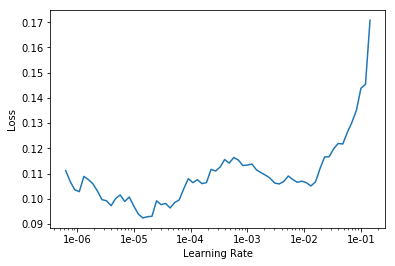

In [0]:
learn.lr_find()
learn.recorder.plot()

We observe the fastest drop in loss from after 1e-6 until 1e-05

In [0]:
learn.fit_one_cycle(6, max_lr=slice(1e-06, 1e-05)) # Recall: Rule of thumb is that the second is 1/10th of the first 

epoch,train_loss,valid_loss,accuracy,time
0,0.092780,0.091028,0.967882,03:33
1,0.108665,0.089996,0.967882,03:32
2,0.107271,0.089399,0.968427,03:43
3,0.107417,0.089592,0.967882,03:36
4,0.101053,0.089259,0.968608,03:42
5,0.106516,0.089820,0.967882,03:40


In [0]:
learn.save('stage-2') # This is the model with the last few layers unfrozen and trained 

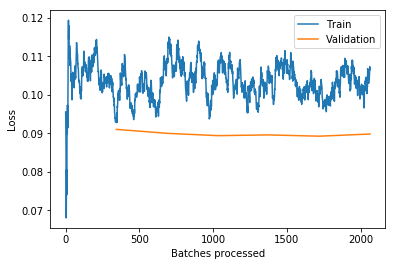

In [0]:
learn.recorder.plot_losses() # Lets see how the loss performed over batches 

Now that the last few layers are producing good results, lets implement differential learning rates to lower layers as well.

The lower layers need to be altered less, so it is a good practice to set each l.r. to be 10 times smaller than the next one.

In [0]:
learn.unfreeze()

Question: Do we just train with learn.fit_one_cycle() for learning rates [5e-6, 5e-5]? 

Or should we rerun learn.lr_find() with unfrozen architecture to confirm that lr of 5e-06 is best?

Lets try

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


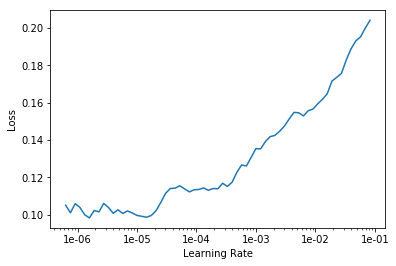

In [0]:
learn.lr_find()
learn.recorder.plot()

Again between 5e-06 and 1e-05 looks best 

In [0]:
learn.fit_one_cycle(4, max_lr=slice(5e-06, 5e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.095361,0.086264,0.970786,04:00
1,0.096421,0.083854,0.970241,04:00
2,0.093232,0.079153,0.971330,04:02
3,0.087033,0.078408,0.971693,04:01


The model performance has __________

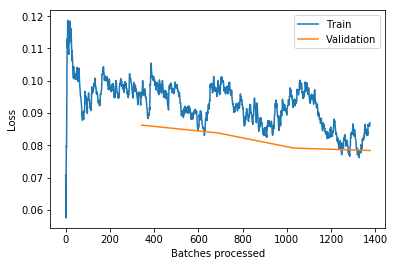

In [0]:
learn.recorder.plot_losses() # Lets see how the loss performed over batches 

In [0]:
learn.save('stage-3') # This is the model with all layers unfrozen and trained 

In [0]:
learn.load('stage-2') #Save the model that had first few layers frozen, and last layer group already trained 
learn.unfreeze() # Unfreeze all layers now 

epoch,train_loss,valid_loss,accuracy,time
0,0.101027,0.088443,0.968790,03:50
1,0.103978,0.088993,0.968608,03:50
2,0.103650,0.086667,0.968971,03:51
3,0.098487,0.086938,0.968427,03:52


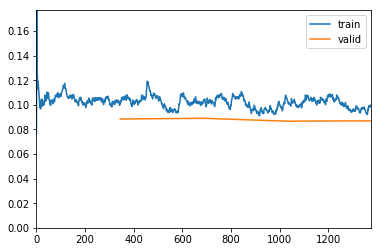

In [0]:
# The fit() method implements cosine annealing. i.e. lr decreases following the cosine function, 
# getting smaller and smaller so that the algorithm does not overshoot
learn.fit(lr=1e-06, epochs=4)

In [0]:
learn.save('stage-4') # Model with last layer group trained, then unfrozen, then all layers trained with cosine annealing 

Model with all layers unfrozen, trained and cyclic trained (stage-3) was best. 

Lets use that. 

In [0]:
learn.load('stage-3')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

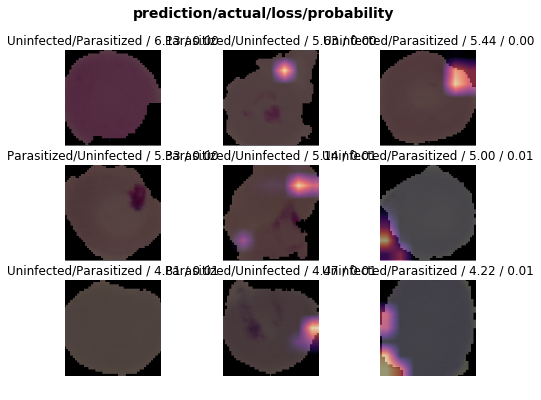

In [0]:
interp.plot_top_losses(9, figsize=(8,6))

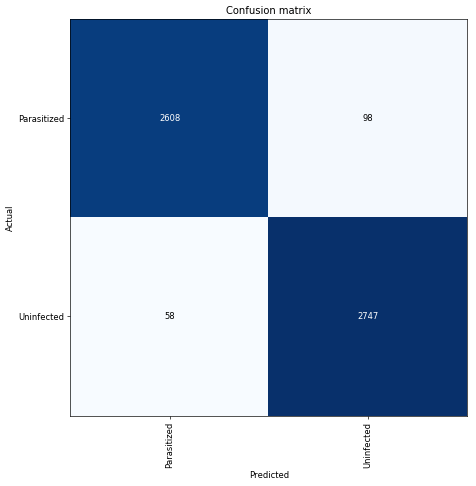

In [0]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

#### Making predictions

In [0]:
pred_data = ImageDataBunch.from_folder(path,
                                      train='',
                                      valid_pct=0.2,
                                      ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                      size=224, bs=64).normalize(imagenet_stats)

In [0]:
model = cnn_learner(data, base_arch=models.resnet34, metrics=accuracy, model_dir='/model').load('stage-3')

In [0]:
pred_data.single_from_classes(path, pred_data.classes) #Empty data for inference

ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: cell_images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: cell_images;

Test: None

Category Uninfected

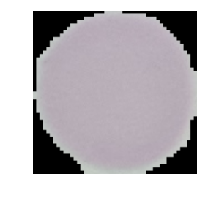

In [0]:
x,y = data.valid_ds[3]
x.show()
data.valid_ds.y[3]

In [0]:
pred_class,pred_idx,outputs = model.predict(x)
pred_class

Category Uninfected